In [23]:
import matplotlib.pyplot as plt
import numpy as np
import fastf1 as f1
from matplotlib.collections import LineCollection
import matplotlib as mpl

In [24]:
year = int(input("Enter year, earliest 2018: "))

if year < 2018:
    raise ValueError("Year must be 2018 or later.")

schedule = f1.get_event_schedule(year)
available_weekends = schedule[['RoundNumber', 'EventName']]

# Print the race weekends in the desired format
print("Available race weekends:")
for _, row in available_weekends.iterrows():
    print(f"{row['RoundNumber']}: {row['EventName']}")

wknd = int(input("Enter race weekend number: "))

if (year == 2025 and wknd > 5) or wknd not in available_weekends['RoundNumber'].values:
    raise ValueError("Weekend number is not valid for the selected year.")


ses = 'R'
colormap = mpl.cm.plasma

session = f1.get_session(year, wknd, ses)
weekend = session.event
session.load()


Available race weekends:
0: Pre-Season Testing
1: Australian Grand Prix
2: Chinese Grand Prix
3: Japanese Grand Prix
4: Bahrain Grand Prix
5: Saudi Arabian Grand Prix
6: Miami Grand Prix
7: Emilia Romagna Grand Prix
8: Monaco Grand Prix
9: Spanish Grand Prix
10: Canadian Grand Prix
11: Austrian Grand Prix
12: British Grand Prix
13: Belgian Grand Prix
14: Hungarian Grand Prix
15: Dutch Grand Prix
16: Italian Grand Prix
17: Azerbaijan Grand Prix
18: Singapore Grand Prix
19: United States Grand Prix
20: Mexico City Grand Prix
21: São Paulo Grand Prix
22: Las Vegas Grand Prix
23: Qatar Grand Prix
24: Abu Dhabi Grand Prix


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '1', '16', '4', '63', '12', '44', '55', '23', '6', '14', '30', '87', '31', '27', '18', '7', '5', '22', '10']


In [25]:
# Retrieve and format the list of available drivers
drivers = session.laps['Driver'].unique()
available_drivers_str = ', '.join(drivers)

print(f"Available drivers: {available_drivers_str}")

Available drivers: PIA, VER, LEC, NOR, RUS, ANT, HAM, SAI, ALB, HAD, ALO, LAW, BEA, OCO, HUL, STR, DOO, BOR, TSU, GAS


In [26]:
drivers = input("Enter driver codes separated by commas: ").split(",")

drivers = [driver.strip() for driver in drivers]

# Assign a unique color to each driver
driver_colors = {driver.strip(): mpl.cm.tab10(i) for i, driver in enumerate(drivers)}

In [27]:
# Loop through each driver and collect telemetry data
driver_telemetry = {}
for driver in drivers:
    driver = driver.strip()
    lap = session.laps.pick_drivers(driver).pick_fastest()
    driver_telemetry[driver] = {
        "x": lap.telemetry['X'].values,
        "y": lap.telemetry['Y'].values,
        "speed": lap.telemetry['Speed'].values
    }

# Use the first driver's telemetry as the reference
reference_driver = drivers[0].strip()
x_telemetry = driver_telemetry[reference_driver]["x"]
y_telemetry = driver_telemetry[reference_driver]["y"]

# Determine the minimum length of telemetry data across all drivers
min_length = min(len(driver_telemetry[driver]["speed"]) for driver in drivers)

fastest_driver = []

# Determine the fastest driver at each point
for i in range(min_length):
    max_speed = -1
    fastest = None
    for driver in drivers:
        driver = driver.strip()
        speed = driver_telemetry[driver]["speed"][i]
        if speed > max_speed:
            max_speed = speed
            fastest = driver
    fastest_driver.append(fastest)


In [28]:
points = np.array([x_telemetry, y_telemetry]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

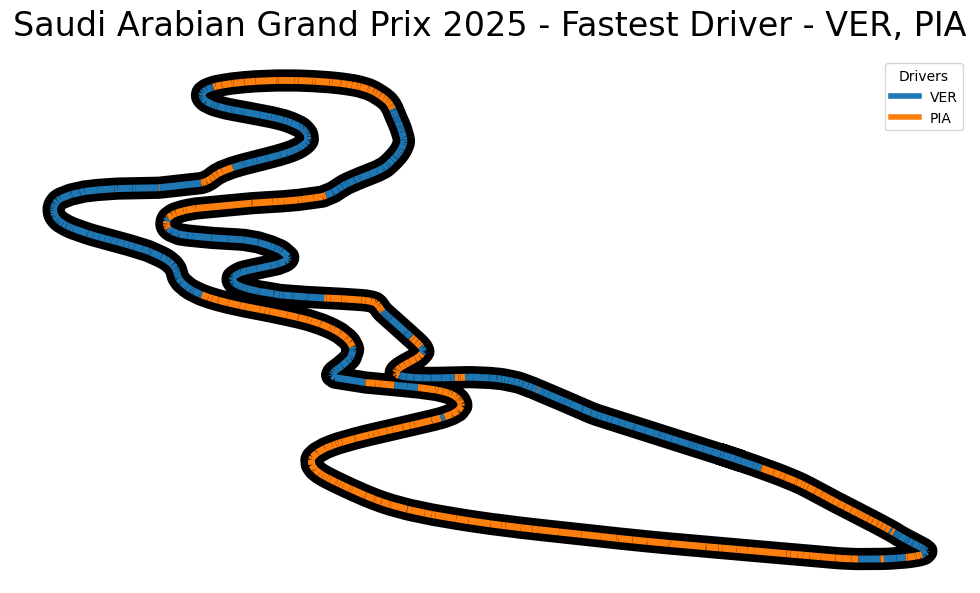

In [29]:
# Map drivers to colors for the plot
colors = [driver_colors[driver] for driver in fastest_driver]

# Create the plot
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(12, 6.75))
fig.suptitle(f'{session.event['EventName']} {year} - Fastest Driver - {", ".join(drivers)}', size=24, y=0.97)

# Adjust margins and turn off axis
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
ax.axis('off')

# Plot the background track line
ax.plot(x_telemetry, y_telemetry, color='black', linestyle='-', linewidth=16, zorder=0)

# Create a LineCollection with driver-specific colors
lc = LineCollection(segments, colors=colors, linestyle='-', linewidth=5)

# Add the collection to the plot
ax.add_collection(lc)

# Create a legend for the drivers
legend_handles = [mpl.lines.Line2D([0], [0], color=color, lw=4, label=driver) for driver, color in driver_colors.items()]
ax.legend(handles=legend_handles, loc='upper right', title="Drivers")

# Show the plot
plt.show()